<a href="https://colab.research.google.com/github/gilsunkan/gilsunkan/blob/main/diabetes_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: Сахарный диабет

## `Задача`: разработка прогностической модели для выявления сахарного диабета

## Библиотеки

In [3]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [4]:
# 🔢 Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Модели и пайплайны
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# 🔍 Модельная оптимизация
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid, StratifiedKFold

# 📈 Метрики
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)

# ⚙️ Разное
from tqdm import tqdm
from datetime import date, datetime
import time
import re
import plotly.express as px
import plotly.io as pio
from scipy.stats import mode
import plotly.express as px
import warnings
from IPython.display import display
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.utils.validation')
warnings.simplefilter(action='ignore', category=FutureWarning)

# ML - библиотеки
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Константы

In [6]:
RANDOM_STATE=654321
TEST_SIZE = 0.3

## Сервисные функции

In [7]:
def df_overview (df):
    display(df.head(3))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    display(df.info())
    print(' ')
    print(f'Полных дубликатов: {df.duplicated().sum()}')
    print(' ')

    if df.isna().sum().sum() == 0:
        print(f'В таблице нет пропущенных значений.')
    else:
        print(' ')
        print((df.isna().sum()/df.shape[0] * 100).round(2).sort_values(ascending=False))
        print((df.isna().sum().sum()/df.shape[0] * 100).round(2))

In [8]:
def preprocessor(df):
    print("-" * 50)
    print('Количество пропусков в каждом из столбцов:')
    print(df.isna().sum())
    print("-" * 50)

    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print("-" * 50)

    for col in df.select_dtypes(include='object').columns:
        print(f"Столбец: {col}")
        print(df[col].unique())
        print("-" * 50)

# Загрузка и первичный обзор данных

In [22]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes /diabetes.csv', sep = ',')
#data = pd.read_csv('diabetes_ds.csv', sep = ',')
display(data.head())
display(data.tail())

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Ферритин,Прокальцитонин,Альбумин,Лактат,ЛДГ,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антикоагулянты, препарат 2","Антиагреганты, препарат 1","Антиагреганты, препарат 2",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий),Блокада НП Гисса,Блокада НП Гисса (комментарий),Удлинение интервала QT,AV- блокада,ХБП (исходн),ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.4,5.33,163.0,0.0,9.61,31.9,3.07,201.0,8.0,4.14,2.25,0.97,3.27,5.77,6.5,0.19,NaN,NaN,NaN,NaN,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.46,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.7,5.01,130.0,0.0,10.48,19.0,1.99,288.0,5.0,3.43,1.31,1.19,1.88,5.91,6.1,NaN,NaN,NaN,46.0,NaN,NaN,12.0,14.0,NaN,2358.0,10.10,107.28,67.22,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,2.0,1.0,1,1.0,1.0,0.0,0.0,1.0,умеренная гипертрофия,1,полная блокада,0.0,0,с3б,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.3,NaN,161.0,0.0,5.40,25.6,1.38,114.0,10.0,4.23,2.69,0.94,3.50,6.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.68,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,0.0,0.0,2.0,1.0,1,1.0,0.0,0.0,0.0,1.0,NaN,1-2,NaN,0.0,1,с3,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.8,4.47,134.0,0.0,8.50,13.3,1.13,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,NaN,NaN,43.6,NaN,327.0,17.9,23.8,23.3,454.6,10.78,91.20,74.67,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,NaN,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,1,NaN,0.0,1,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.3,5.44,166.0,0.0,9.06,28.3,2.56,226.0,5.0,3.25,1.45,1.30,1.50,9.48,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.59,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,2.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0,1.0


,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Ферритин,Прокальцитонин,Альбумин,Лактат,ЛДГ,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антикоагулянты, препарат 2","Антиагреганты, препарат 1","Антиагреганты, препарат 2",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий),Блокада НП Гисса,Блокада НП Гисса (комментарий),Удлинение интервала QT,AV- блокада,ХБП (исходн),ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
479,155.0,2.0,47.0,2.0,168.0,58.0,20.5,4.32,131.0,0.0,6.62,11.5,0.76,208.0,NaN,7.03,2.99,3.67,0.92,5.45,NaN,NaN,NaN,NaN,45.7,NaN,NaN,33.1,42.4,NaN,NaN,6.26,72.00,85.91,140.7,5.27,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,2,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0,0.0
480,302.0,2.0,69.0,1.0,170.0,61.0,21.1,4.40,140.0,0.0,6.90,1.4,0.10,273.0,3.0,5.93,3.37,1.49,2.98,5.00,5.9,NaN,NaN,NaN,NaN,NaN,NaN,23.8,24.8,14.0,596.5,4.80,93.00,71.91,NaN,NaN,NaN,2.73,3.16,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,38,0.0
481,345.0,2.0,62.0,1.0,175.0,75.0,24.5,4.59,147.0,0.0,9.47,17.6,1.67,263.0,NaN,3.41,2.51,0.78,3.37,6.17,NaN,NaN,NaN,NaN,39.0,NaN,NaN,52.0,38.0,13.4,9151.0,5.93,90.06,78.52,138.9,3.90,31.3,1.32,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,2.0,NaN,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,1,NaN,0.0,0,0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,35,0.0
482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.0,NaN,91.0,28.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,403.0,NaN,142.0,NaN,NaN,NaN,22.0,NaN,56.0,NaN,144.0,NaN,357.0,NaN,445.0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Для удобного проведения анализа первым делом необходимо изменить названия столбцов, приведя их к змеиному регистру*

In [24]:
data.columns = (data.columns
                    .str.strip()
                    .str.replace(r'[ \t\n\r\f\v/-]+', '_', regex=True)
                    .str.replace(',', '', regex=False)
                    .str.replace(r'\(.*?\)', '', regex=True)
                    .str.rstrip('_')
                    .str.lower())

In [25]:
#diabetes = pd.read_excel(r'./data/diabetes_ds.xlsx')
# legend = pd.read_excel(r'./data/diabetes_ds.xlsx', sheet_name='Легенда')

In [26]:
#df_overview(data)

*В исходном наборе данных содержалось **более 100 признаков**. Однако их включение в модель без предварительного отбора представляло бы методологическую ошибку, поскольку некоторые из них являются либо неинформативными, либо представляют собой прямую утечку данных о целевом признаке.*

*Так, например, переменные вроде `Перенёс КВИ` не несут значимой прогностической информации в контексте сахарного диабета, а признаки `Метформин` и `Дапаглифлозин` являются индикаторами уже установленного диагноза, поскольку данные лекарственные препараты применяются исключительно в терапии диабета. Использование таких признаков может привести к переобучению модели и необоснованно завышенной точности на тестовых данных.*

*Проведя структурированный анализ всех признаков и проконсультировавшись с профильными специалистами в области эндокринологии, было принято решение сформировать финальный набор признаков, включающий только клинически обоснованные и безопасные с точки зрения прогноза переменные. Именно они были оставлены для дальнейшей предобработки и построения прогностической модели.*

In [27]:
columns_to_learn = [
    'возраст',
    'пол',
    'рост_см',
    'вес_кг',
    'имт_2',
    'эритроциты',
    'гемоглобин',
    'цветовой_показатель',
    'лейкоциты',
    'лимфоциты%',
    'лимфоциты_абс',
    'тромбоциты',
    'соэ',
    'холестерин',
    'лпнп',
    'лпвп',
    'индекс_атерогенности_2',
    'глюкоза',
    'срб',
    'ферритин',
    'альбумин',
    'лактат',
    'лдг',
    'алт',
    'аст',
    'общий_билирубин',
    'мочевина',
    'креатинин_мкмоль_л',
    'скф_ckd_epi',
    'натрий',
    'калий',
    'ачтв',
    'мно',
    'фибриноген',
    'd_димер',
    'степени_ожирения_по_имт',
    'ожирение',
    'сахарный_диабет'
]

In [28]:
data = data[columns_to_learn]

*На данном этап первичный анализ закончен, можем двигаться к предобработке*

# Предобработка данных

*Выведем общую информацию о датасете*

In [31]:
preprocessor(data)

--------------------------------------------------
Количество пропусков в каждом из столбцов:
возраст                      3
пол                          2
рост_см                      3
вес_кг                       3
имт_2                        2
эритроциты                   5
гемоглобин                   2
цветовой_показатель          3
лейкоциты                    3
лимфоциты%                   3
лимфоциты_абс                4
тромбоциты                   6
соэ                         48
холестерин                  25
лпнп                        38
лпвп                        45
индекс_атерогенности_2      50
глюкоза                     30
срб                        359
ферритин                   454
альбумин                   336
лактат                     474
лдг                        443
алт                         60
аст                         71
общий_билирубин            254
мочевина                   117
креатинин_мкмоль_л          14
скф_ckd_epi                 14
натрий 

*На этапе первичной предобработки было выявлено наличие признаков с высоким уровнем пропущенных значений. Столбцы, в которых доля пропусков превышала допустимый порог (ориентировочно более 30%), были исключены из дальнейшего анализа, поскольку их сохранение могло бы повлиять на устойчивость модели и затруднить интерпретацию результатов. Явные дубликаты отсутствуют*

In [35]:
empty_columns = ['лактат',
                 'ферритин',
                 'лдг',
                 'd_димер',
                 'фибриноген',
                 'срб',
                 'ачтв',
                 'альбумин',
                 'мно',
                 'общий_билирубин',
                 'натрий',
                 'калий',
                 'мочевина']

data = data.drop(empty_columns, axis = 1)

KeyError: "['лактат', 'ферритин', 'лдг', 'd_димер', 'фибриноген', 'срб', 'ачтв', 'альбумин', 'мно', 'общий_билирубин', 'натрий', 'калий', 'мочевина'] not found in axis"

In [36]:
preprocessor(data)

--------------------------------------------------
Количество пропусков в каждом из столбцов:
возраст                     3
пол                         2
рост_см                     3
вес_кг                      3
имт_2                       2
эритроциты                  5
гемоглобин                  2
цветовой_показатель         3
лейкоциты                   3
лимфоциты%                  3
лимфоциты_абс               4
тромбоциты                  6
соэ                        48
холестерин                 25
лпнп                       38
лпвп                       45
индекс_атерогенности_2     50
глюкоза                    30
алт                        60
аст                        71
креатинин_мкмоль_л         14
скф_ckd_epi                14
степени_ожирения_по_имт     3
ожирение                    2
сахарный_диабет             6
dtype: int64
--------------------------------------------------
Количество дубликатов: 1
--------------------------------------------------


*После удаления таких признаков, в оставшихся переменных наблюдается незначительное количество пропусков. Принято решение не заполнять их на данном этапе, а отложить обработку до проведения разведочного анализа данных (EDA). В рамках EDA будут построены распределения и визуализации, позволяющие понять природу данных и выбрать наиболее подходящую стратегию импутации (медиана, мода, либо более продвинутые методы).*

*Также был выявлен один дубликат по строкам. Он был удалён, чтобы избежать смещения статистик и переобучения модели на повторяющихся данных.*

In [37]:
# посмотрим на типы наших данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   возраст                  481 non-null    float64
 1   пол                      482 non-null    float64
 2   рост_см                  481 non-null    float64
 3   вес_кг                   481 non-null    float64
 4   имт_2                    482 non-null    float64
 5   эритроциты               479 non-null    float64
 6   гемоглобин               482 non-null    float64
 7   цветовой_показатель      481 non-null    float64
 8   лейкоциты                481 non-null    float64
 9   лимфоциты%               481 non-null    float64
 10  лимфоциты_абс            480 non-null    float64
 11  тромбоциты               478 non-null    float64
 12  соэ                      436 non-null    float64
 13  холестерин               459 non-null    float64
 14  лпнп                     4

*Как видим, у нас все столбцы имеют тип **float**, хотя, тот же `пол` должен иметь только 2 значения: **1** и **0**. Все это из-за пропусков, которые будут обработаны в EDA. И сразу после их обработки мы приведем типы данных в порядок*

*Мы уже обработали названия столбцов, приведя их змеиному регистру. Но для полного удобства стоит перевести их на английский*

In [41]:
rename_dict = {
    'возраст': 'age',
    'пол': 'sex',
    'рост_см': 'height',
    'вес_кг': 'weight',
    'имт_2': 'bmi',
    'эритроциты': 'erythrocytes',
    'гемоглобин': 'hemoglobin',
    'цветовой_показатель': 'color_index',
    'лейкоциты': 'leukocytes',
    'лимфоциты%': 'lymphocytes_per',
    'лимфоциты_абс': 'lymphocytes_abs',
    'тромбоциты': 'platelets',
    'соэ': 'esr',
    'холестерин': 'cholesterol',
    'лпнп': 'ldl',
    'лпвп': 'hdl',
    'индекс_атерогенности_2': 'atherogenic_index',
    'глюкоза': 'glucose',
    'алт': 'alt',
    'аст': 'ast',
    'креатинин_мкмоль_л': 'creatinine',
    'скф_ckd_epi': 'gfr',
    'степени_ожирения_по_имт': 'obesity_stage_bmi',
    'ожирение': 'obesity',
    'сахарный_диабет': 'diabetes'
}
data.rename(columns=rename_dict, inplace=True)

**Вывод по предобработке данных:**
- Были удалены признаки, имеющие более **30 %** пропусков
- Названия столбцов переведены с **русского** на **английский**
- В ходе удаления признаков образовался **1 дубликат**, который был удален
- Осташиеся пропуски оставлены на обработку в EDA

# EDA

**В этом разделе мы проведём исследовательский анализ данных (EDA), чтобы:**
- получить общее представление о распределении числовых признаков
- выявить потенциальные выбросы и определить наличие бинарных признаков

**Мы визуализируем каждый числовой столбец с помощью трёх графиков:**
- **гистограммы** с линией плотности распределения
- ящиковой диаграммы (**boxplot**)
- и скрипичного графика (**violin plot**) для оценки симметрии и плотности значений

*Это поможет выявить особенности распределения данных, заполнить пропуски и заложит основу для дальнейшей предобработки и построения моделей*

Выделение тестовой выборки

In [44]:
train, test = train_test_split(data,
                               stratify = data['diabetes'],
                               test_size=TEST_SIZE,
                               random_state=RANDOM_STATE)

In [45]:
# Разделим числовые данные на 2 категории: бинарные и остальные
numerical_cols = data.columns.tolist()

binary_cols = []
for col in numerical_cols:
    if isinstance(data[col], pd.Series):
        unique_vals = data[col].dropna().unique()
        if len(unique_vals) <= 2:
            binary_cols.append(col)

not_binary = data.drop(columns=binary_cols).columns.tolist()

*Теперь визуализируем данные*

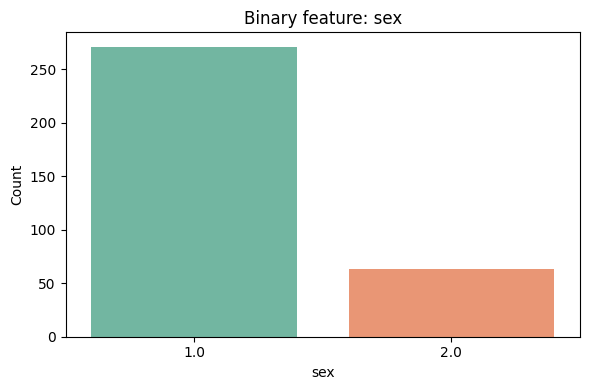

Распределение признака sex:
 Значение 1.0: 394 записей (82.43%)
 Значение 2.0: 84 записей (17.57%)
 ✅ Пропущенных значений нет




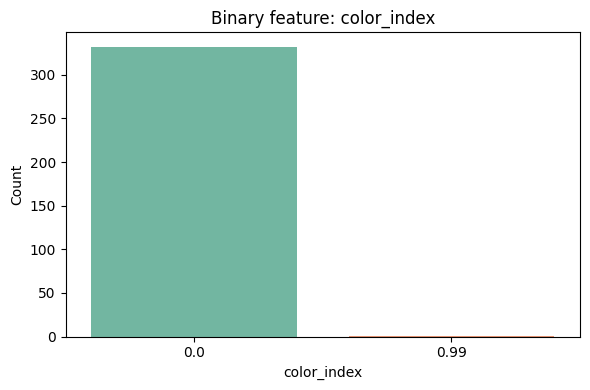

Распределение признака color_index:
 Значение 0.0: 476 записей (99.79%)
 Значение 0.99: 1 записей (0.21%)
 🔻 Пропущенные значения: 1




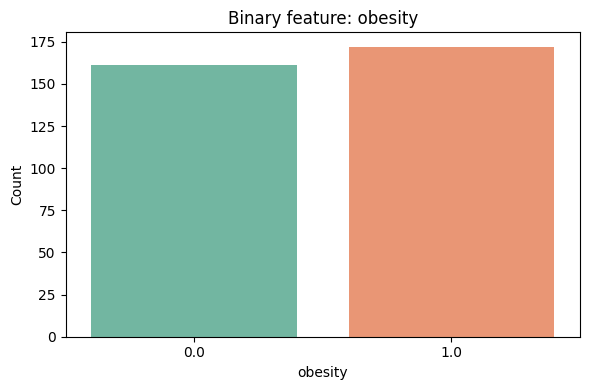

Распределение признака obesity:
 Значение 1.0: 243 записей (50.94%)
 Значение 0.0: 234 записей (49.06%)
 🔻 Пропущенные значения: 1




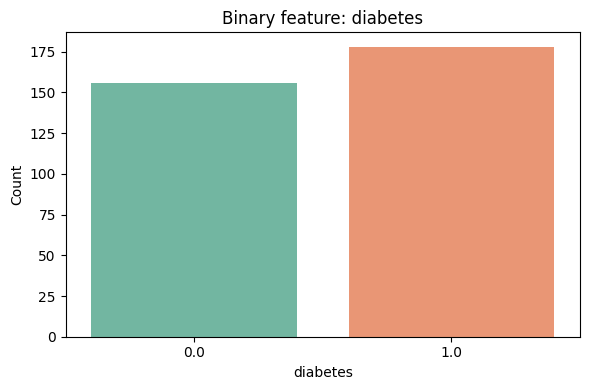

Распределение признака diabetes:
 Значение 1.0: 255 записей (53.35%)
 Значение 0.0: 223 записей (46.65%)
 ✅ Пропущенных значений нет




In [46]:
# Для бинарных признаков: визуализация + численное, процентное распределение
for col in binary_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, palette="Set2")
    plt.title(f'Binary feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    counts = data[col].value_counts()
    percentages = data[col].value_counts(normalize=True) * 100
    missing = data[col].isna().sum()

    print(f'Распределение признака {col}:')
    for value in counts.index:
        print(f' Значение {value}: {counts[value]} записей ({percentages[value]:.2f}%)')

    if missing > 0:
        print(f' 🔻 Пропущенные значения: {missing}')
    else:
        print(' ✅ Пропущенных значений нет')
    print('\n')

📊 **Анализ бинарных признаков**

---

`diabetes` — целевая переменная  
- Значение **`1.0`**: **255** записей (**53.35%**)  
- Значение **`0.0`**: **223** записей (**46.65%**)  
- ✅ Пропущенных значений нет

*Комментарий:*  
**Целевой признак сбалансирован** — классы распределены почти поровну, что положительно влияет на устойчивость моделей.  

---

`sex` — пол пациента  
- Значение **`1.0`**: **394** записей (**82.43%**)  
- Значение **`2.0`**: **84** записей (**17.57%**)  
- ✅ Пропущенных значений нет

*Комментарий:*  
Признак **несбалансирован**, с выраженным перевесом в сторону значения **`1.0`**.

---

`color_index` — цветовой индекс  
- Значение **`0.0`**: **476** записей (**99.79%**)  
- Значение **`0.99`**: **1** запись (**0.21%**)  
- 🔻 **Пропущенные значения: `1`**

*Комментарий:*  
Признак демонстрирует **крайне несбалансированное распределение**. Единственное альтернативное значение (`0.99`) встречается один раз — этого недостаточно, чтобы использовать его как отдельную категорию.  
➡️ **Стоит удалить данный признак как нерелевантный.**

---

`obesity` — ожирение
- Значение **`1.0`**: **243** записей (**50.94%**)  
- Значение **`0.0`**: **234** запись (**49.06%**)  
- 🔻 **Пропущенные значения: `1`**

*Комментарий:*  
**Признак сбалансирован** — классы распределены почти поровну, что положительно влияет на устойчивость моделей.  
Обработаем пропущенное значение в пайплайне.




*Теперь рассмотрим распределение небинарных признаков*

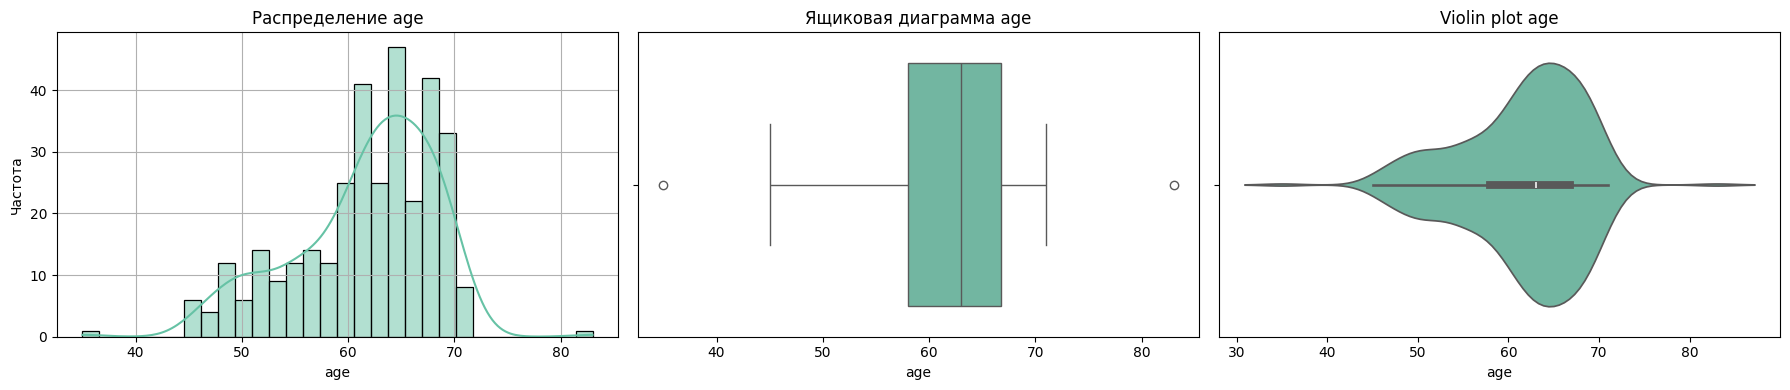

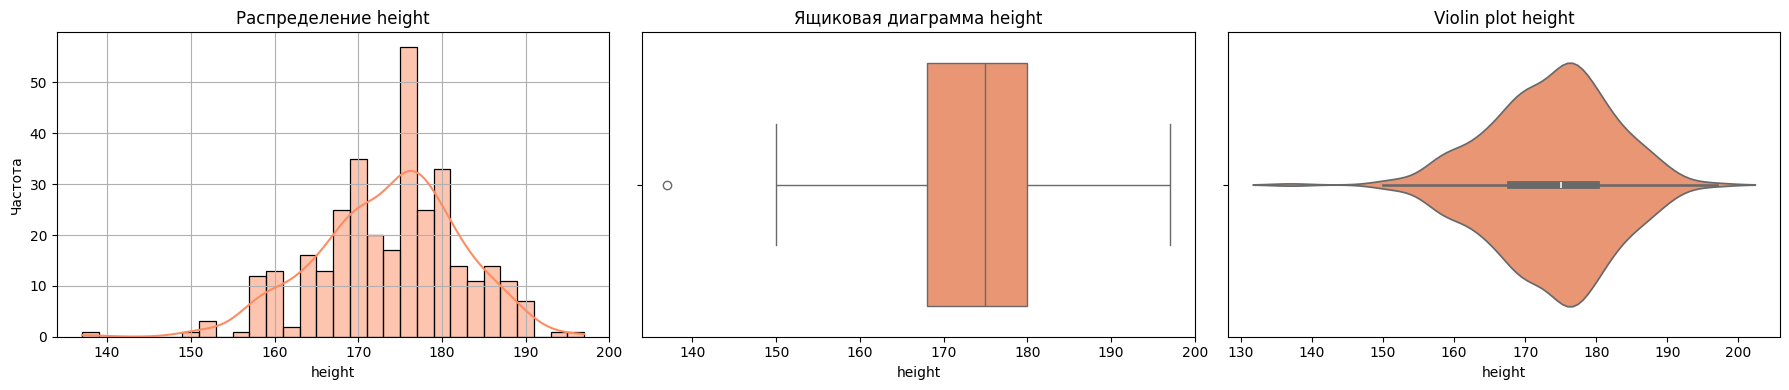

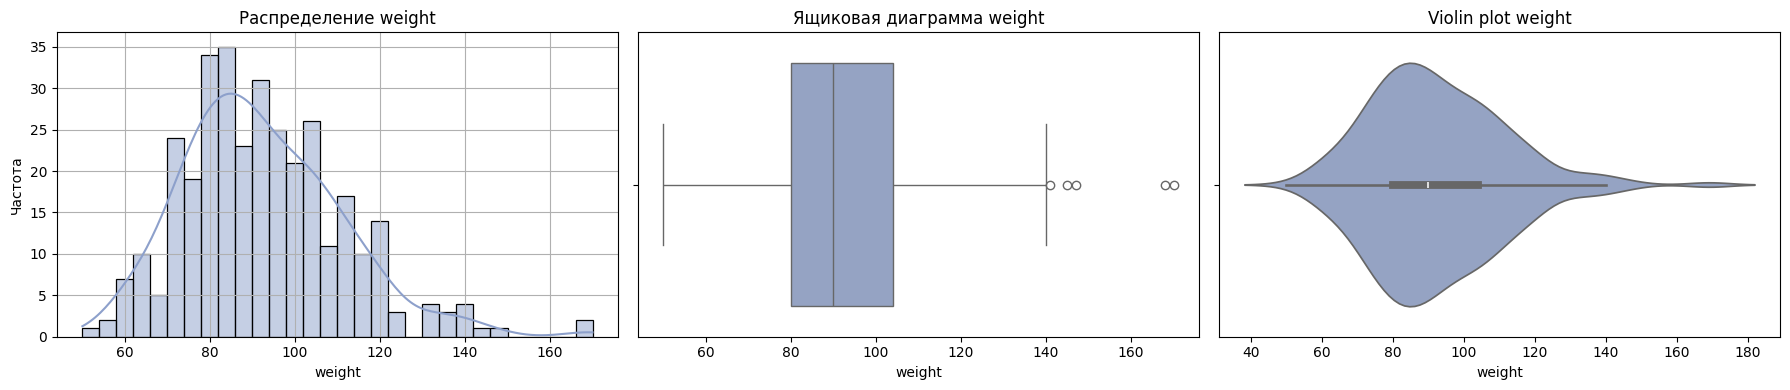

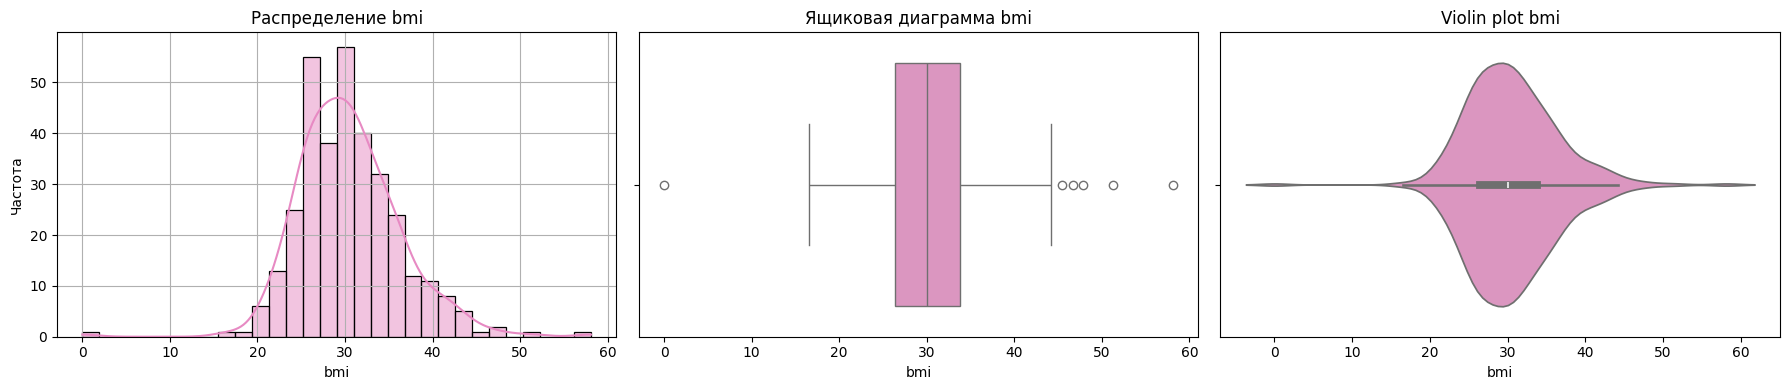

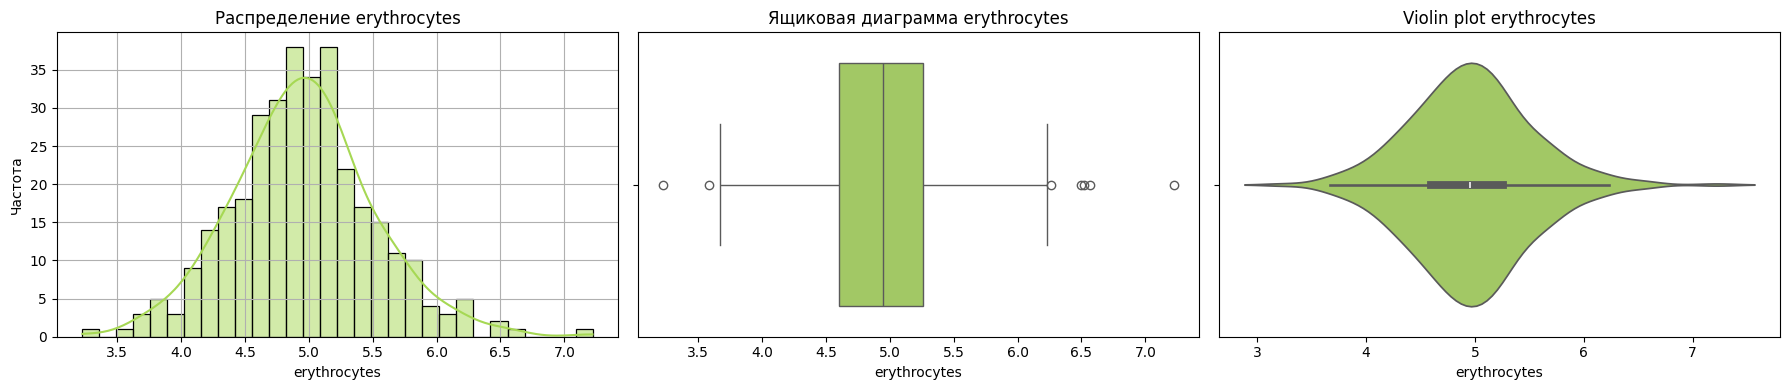

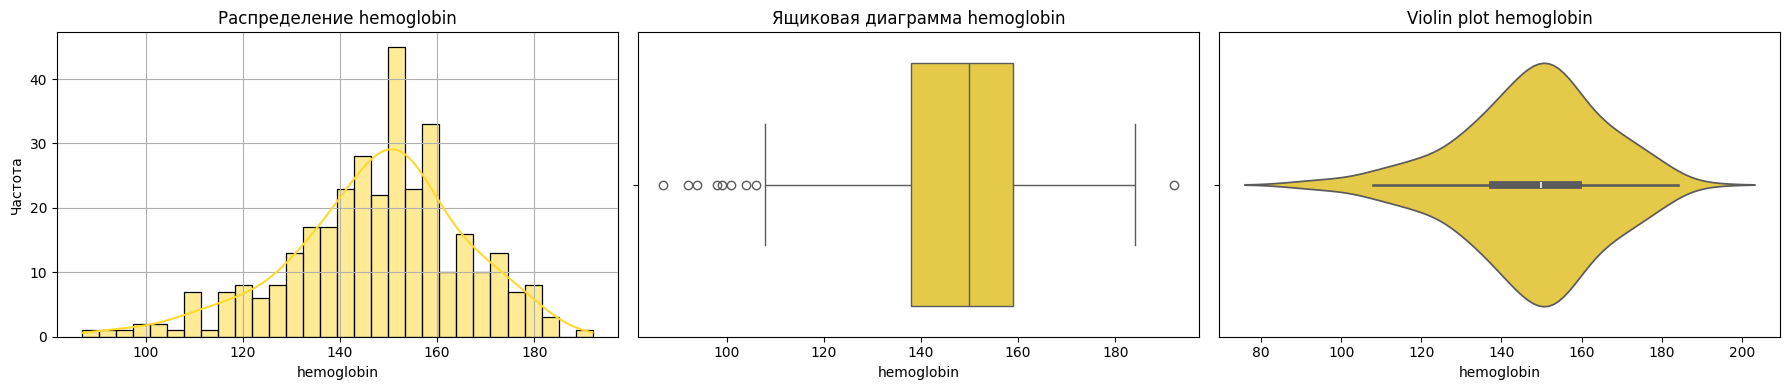

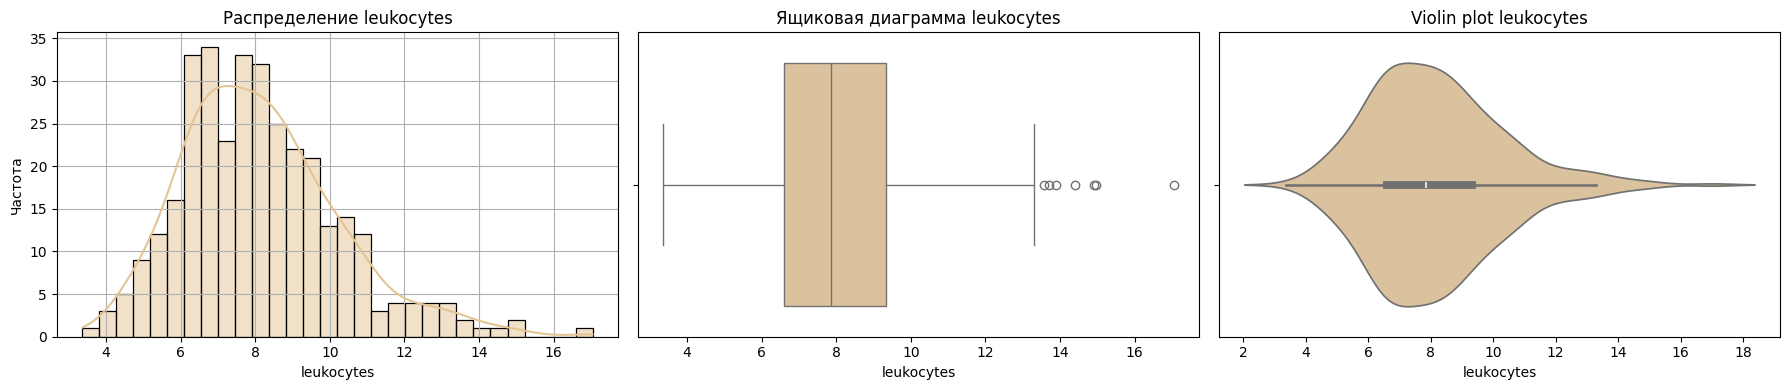

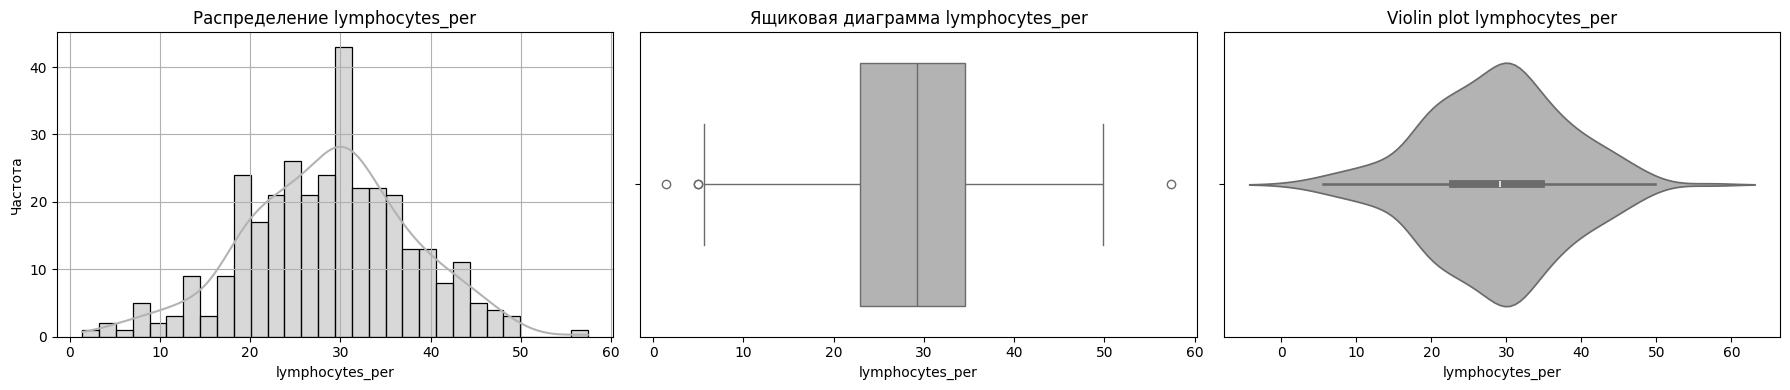

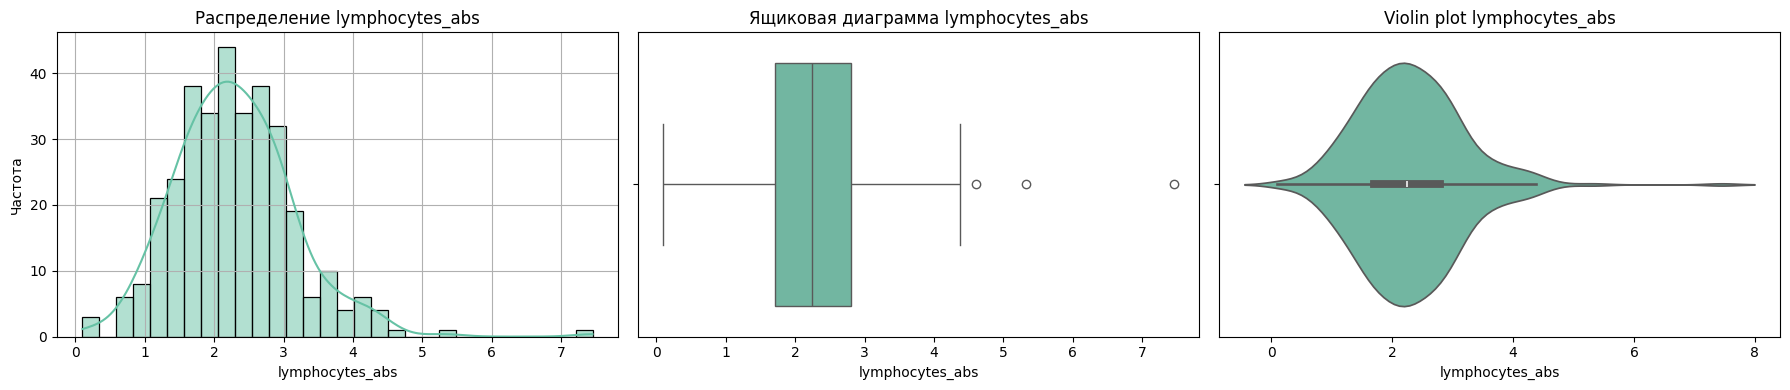

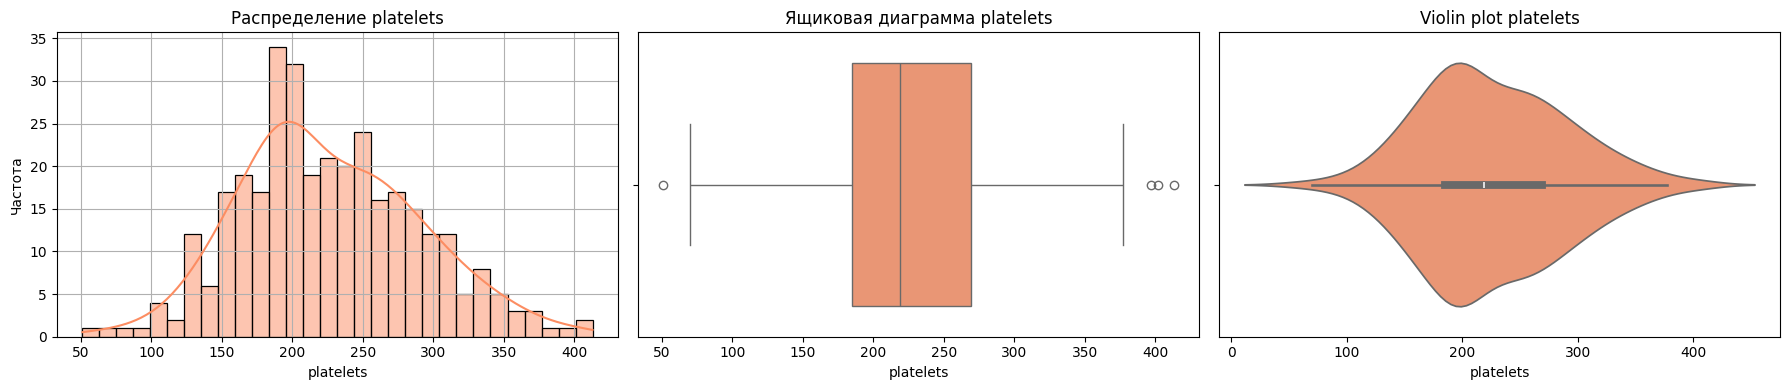

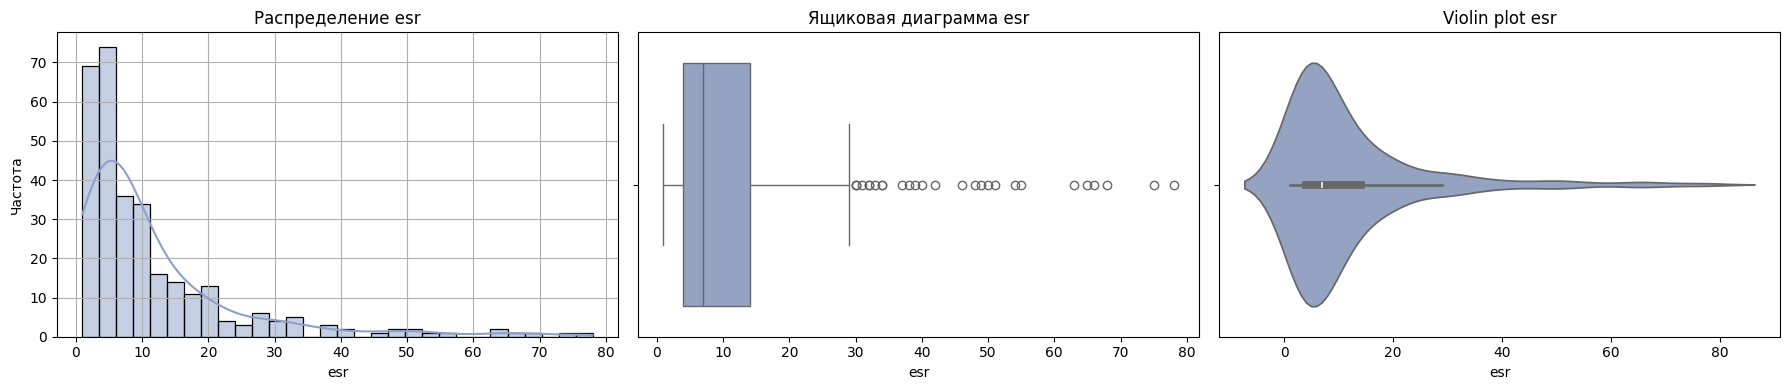

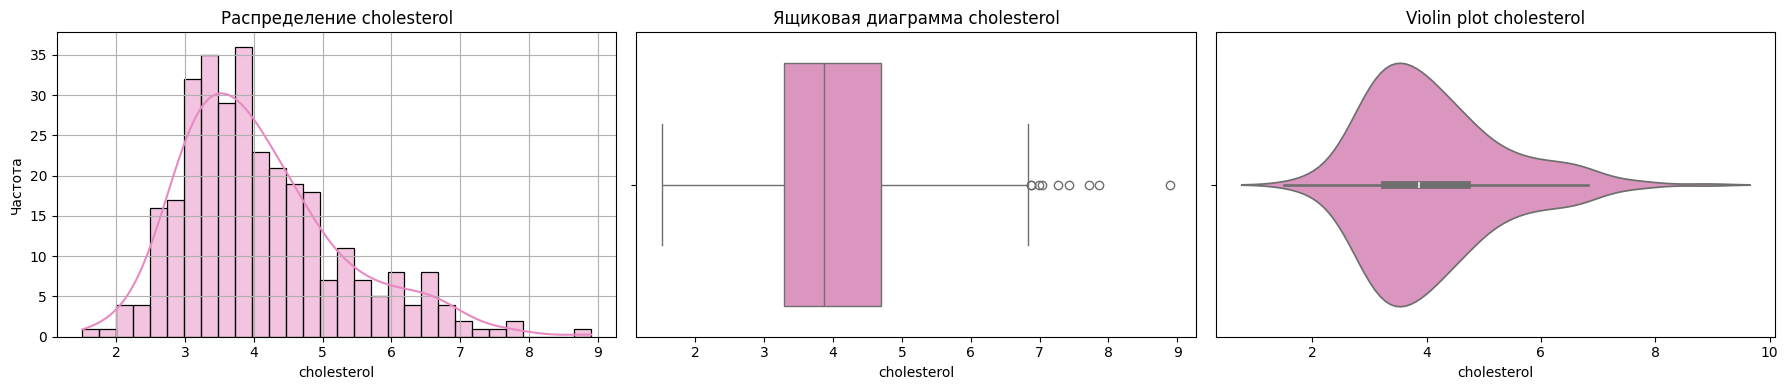

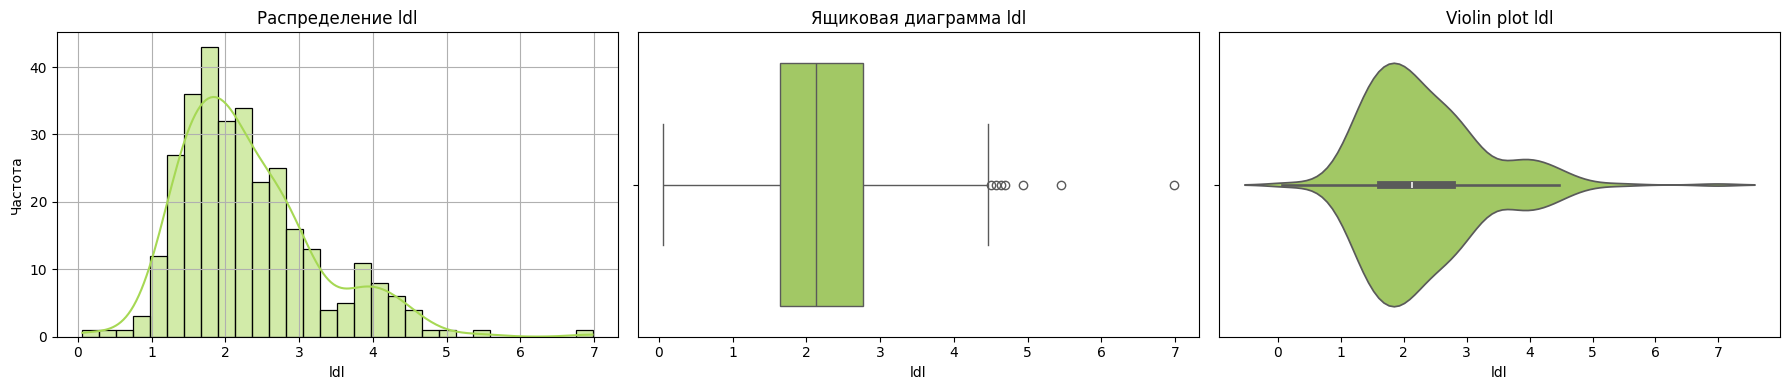

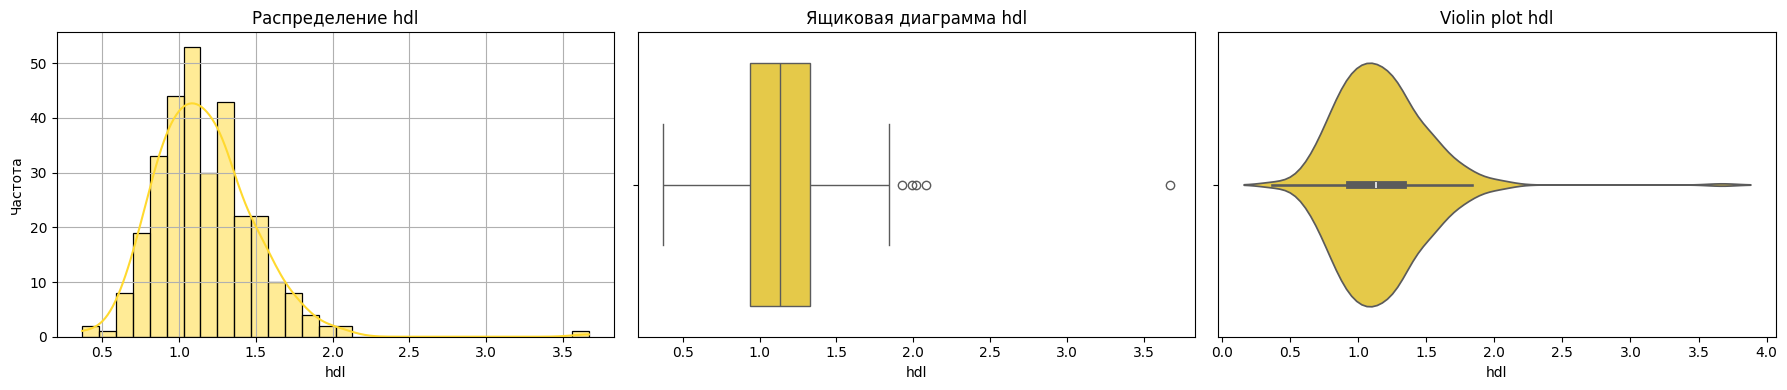

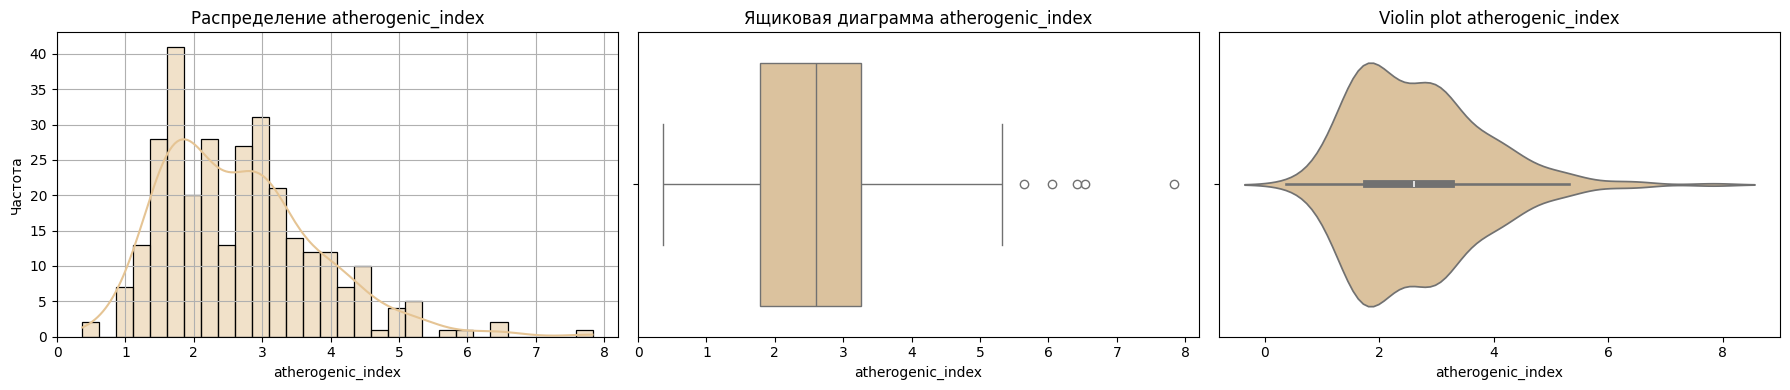

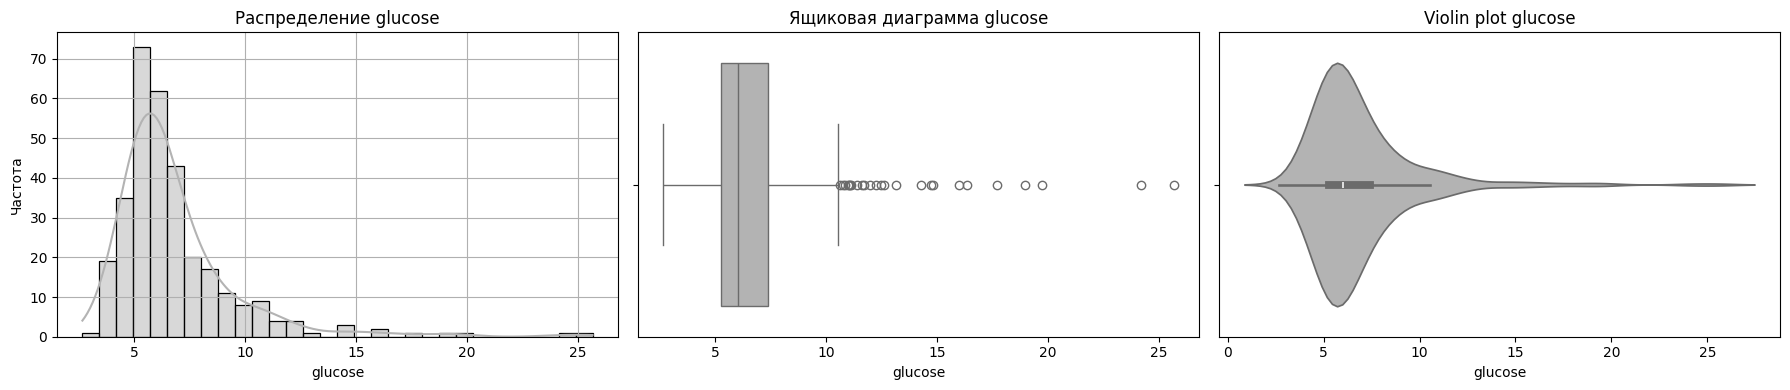

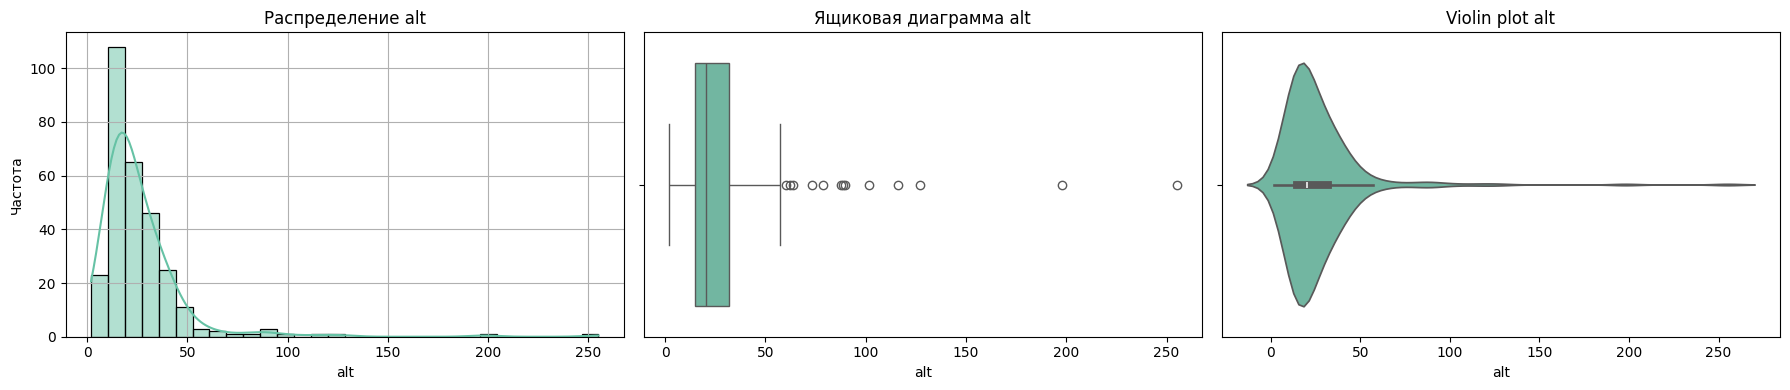

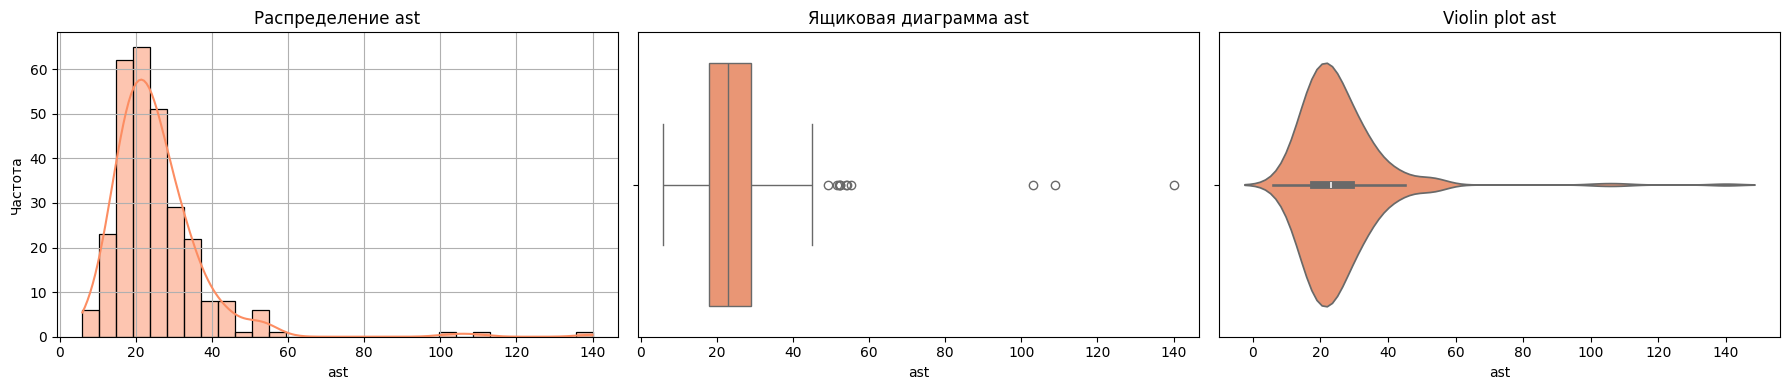

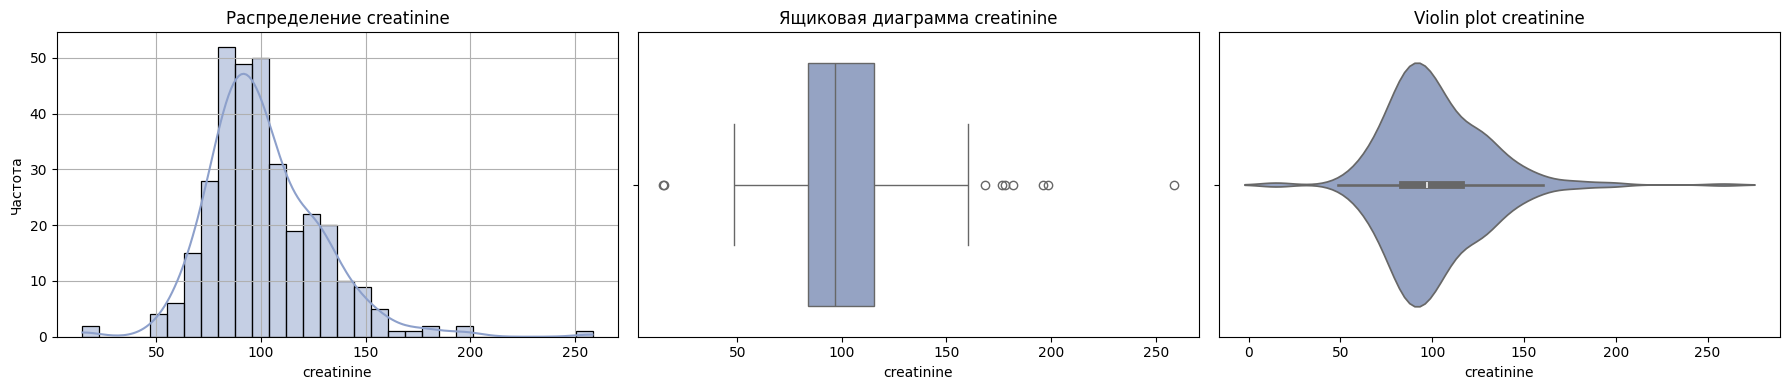

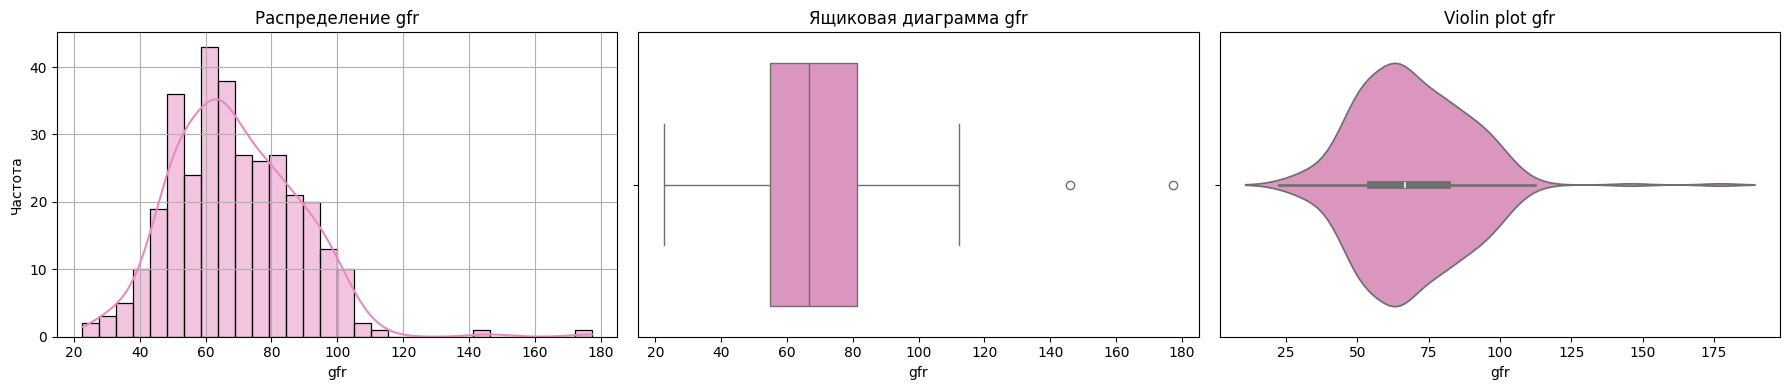

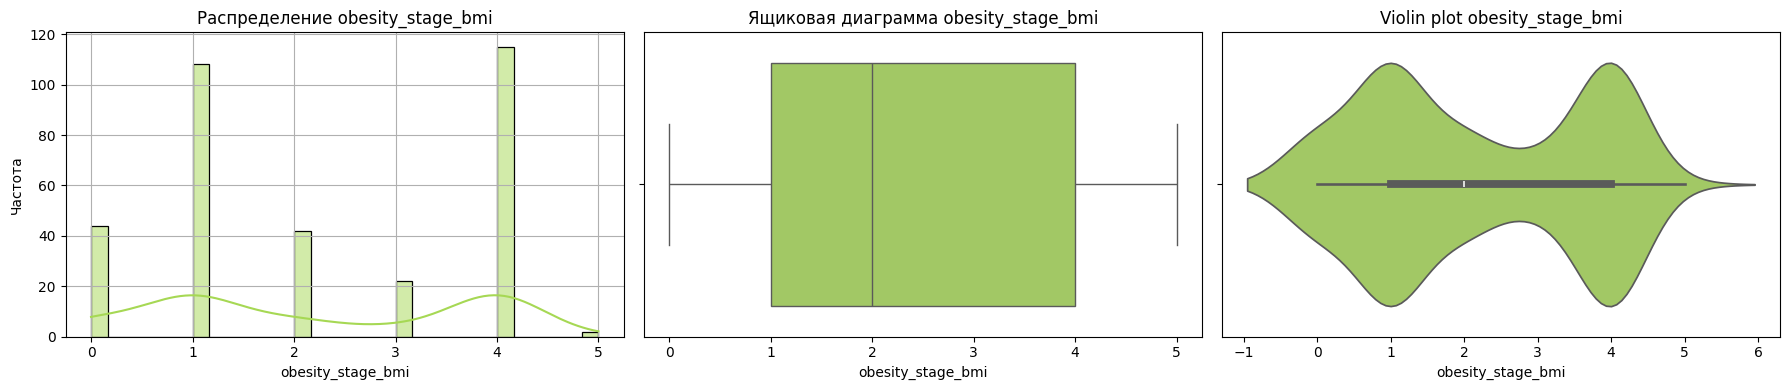

In [67]:
palette = sns.color_palette("Set2", n_colors=len(not_binary))

for i, col in enumerate(not_binary):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Гистограмма
    sns.histplot(
        data=train, x=col, bins=30, kde=True, ax=axes[0],
        color=palette[i], line_kws={"color": "black", "linewidth": 1.5}
    )
    axes[0].set_title(f'Распределение {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    axes[0].grid(True)

    # Ящиковая диаграмма
    sns.boxplot(data=train, x=col, ax=axes[1], color=palette[i])
    axes[1].set_title(f'Ящиковая диаграмма {col}')
    axes[1].set_xlabel(col)

    # Скрипичный график
    sns.violinplot(data=train, x=col, ax=axes[2], color=palette[i])
    axes[2].set_title(f'Violin plot {col}')
    axes[2].set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [61]:
train[not_binary].describe().T

,count,mean,std,min,25%,50%,75%,max
age,334.0,61.589820,6.626638,35.00,58.0000,63.00,66.7500,83.00
height,333.0,173.621622,8.507673,137.00,168.0000,175.00,180.0000,197.00
weight,333.0,92.216216,18.814602,50.00,80.0000,90.00,104.0000,170.00
bmi,334.0,30.458084,5.870124,0.00,26.4250,30.00,33.7500,58.10
erythrocytes,332.0,4.957470,0.555482,3.23,4.6000,4.95,5.2600,7.22
hemoglobin,334.0,147.539222,17.907897,87.00,138.0000,150.00,159.0000,192.00
leukocytes,334.0,8.145299,2.120529,3.37,6.6000,7.87,9.3375,17.04
lymphocytes_per,334.0,28.693204,9.112319,1.40,22.9000,29.20,34.6000,57.40
lymphocytes_abs,334.0,2.296527,0.868311,0.10,1.7025,2.24,2.7975,7.45
platelets,331.0,226.308157,63.511883,51.00,185.0000,219.00,269.0000,413.00


In [55]:
train[not_binary].isna().sum()

,0
age,0
height,1
weight,1
bmi,0
erythrocytes,2
hemoglobin,0
leukocytes,0
lymphocytes_per,0
lymphocytes_abs,0
platelets,3


📊 **Анализ небинарных признаков**

---

`age` — возраст  
- По **гистограмме**: симметричное распределение, значения от **50 до 70 лет**  
- По **ящиковой диаграмме**: отсутствуют значимые выбросы  
- По **violin plot**: плотность сосредоточена вокруг **65 лет**  
🔍 *Комментарий:* **Признак стабилен**, информативен для моделей  
🔧 *Пропусков: нет*  

---

`height` — рост  
- По **гистограмме**: близко к **нормальному**, пик — **~175 см**  
- По **ящиковой диаграмме**: умеренное число выбросов  
- По **violin plot**: симметричная форма  
🔍 *Комментарий:* **Физиологически обоснованный признак**  
🔧 *Пропусков: 1* — можно заполнить медианой

---

`weight` — вес  
- По **гистограмме**: правостороннее распределение, значений **>90 кг** — много  
- По **ящиковой диаграмме**: выбросы в верхней части  
- По **violin plot**: длинный хвост вправо  
🔍 *Комментарий:* **Потенциальный индикатор ожирения**, учитывать выбросы  
🔧 *Пропусков: 1* — можно заполнить медианой

---

`bmi` — индекс массы тела  
- По **гистограмме**: пик около **27**, есть значения до **40+**  
- По **ящиковой диаграмме**: наблюдаются выбросы, в рамках существующих в медицине показателей  
- По **violin plot**: асимметрия  

🔍 *Комментарий:* **Клинически значимый**, отражает риски диабета  
🔧 *Пропусков: нет*, но есть нулевое значение - заполнение по `weight/height`

---

`erythrocytes` — эритроциты  
- По **гистограмме**: распределение близко к симметричному  
- По **ящиковой диаграмме**: наблюдаются выбросы, в рамках существующих в медицине показателей   
- По **violin plot**: хвост вправо

🔍 *Комментарий*: **Показатель отклонений крови**, важен  
🔧 *Пропусков: 2* — можно заполнить средним

---

`hemoglobin` — гемоглобин  
- По **гистограмме**: нормальное распределение, пик **~135**  
- По **ящиковой диаграмме**: минимальные выбросы, в рамках существующих в медицине показателей   
- По **violin plot**: симметричная плотность  

🔍 *Комментарий:* **Клинический параметр**  
🔧 *Пропусков: 0*

---

`leukocytes` — лейкоциты  
- По **гистограмме**: распределение асимметрично, наблюдается пик в районе **7–9**, длинный хвост вправо  
- По **ящиковой диаграмме**: присутствуют умеренные выбросы в правой части  
- По **violin plot**: плотность сосредоточена ближе к **8**, распределение скошено  

🔍 *Комментарий:* **Показатель воспаления**, может отражать инфекционные процессы.  
🔧 *Пропусков: 0*

---

`lymphocytes_per` — процент лимфоцитов  
- По **гистограмме**: распределение близко к симметричному, большинство значений в диапазоне **20–35%**  
- По **ящиковой диаграмме**: присутствуют незначительные выбросы  
- По **violin plot**: плотность равномерная с лёгким смещением  
🔍 *Комментарий:* **Физиологически обоснованный признак**, указывает на иммунные реакции  
🔧 *Пропусков: 0* —

---

`lymphocytes_abs` — абсолютное число лимфоцитов  
- По **гистограмме**: распределение скошено влево, пиковые значения **2–3**  
- По **ящиковой диаграмме**: умеренные выбросы в обе стороны  
- По **violin plot**: плотность сосредоточена около **2.5**, с асимметрией  
🔍 *Комментарий:* **Иммунологический маркер**, информативен для оценки состояния пациента  
🔧 *Пропусков: 0*

---

`platelets` — тромбоциты  
- По **гистограмме**: распределение асимметрично, большинство значений **180–320**, есть редкие экстремумы  
- По **ящиковой диаграмме**: присутствуют незначительные выбросы
- По **violin plot**: плотность основного ядра высока, есть редкие высокие значения  
🔍 *Комментарий:* **Клинически важный показатель**  
🔧 *Пропусков: 3* — можно заполнить медианой

---

`esr` — СОЭ (скорость оседания эритроцитов)  
- По **гистограмме**: ярко выраженное правостороннее распределение, основная масса < **20**  
- По **ящиковой диаграмме**: множество выбросов в верхней части  
- По **violin plot**: плотность резко убывает после **20**  
🔍 *Комментарий:* **Очень чувствительный к воспалению признак**  
🔧 *Пропусков: 27* — можно заполнить медианой

---

`cholesterol` — холестерин  
- По **гистограмме**: умеренно асимметричное, от **4 до 9**  
- По **ящиковой диаграмме**: выбросы  
- По **violin plot**: вытянуто вверх  
🔍 *Комментарий:* **Фактор кардиориска**,  
🔧 *Пропусков: 17* — можно заполнить медианой

---

`hdl` (`лпвп`) — липопротеины высокой плотности  
- По **гистограмме**: нормальное распределение, но вытянуто  
- По **ящиковой диаграмме**: выбросы  
- По **violin plot**: узкий пик  
🔍 *Комментарий:* **Показатель антиатерогенной защиты**, важен  
🔧 *Пропусков: 25* — можно заполнить средним

---

`ldl` (`лпнп`) — липопротеины низкой плотности  
- По **гистограмме**: перекос вправо, значения до **9**  
- По **ящиковой диаграмме**: значительные выбросы  
- По **violin plot**: плотность асимметрична  
🔍 *Комментарий:* **Атерогенный маркер**, важен для прогноза, выбросы проверить   
🔧 *Пропусков: 30* — можно заполнить медианой

---

`atherogenic_index` — индекс атерогенности  
- По **гистограмме**: широкий диапазон, асимметрия  
- По **ящиковой диаграмме**: выбросы  
- По **violin plot**: вытянуто  
🔍 *Комментарий:* **Вторичный признак**, можно рассчитать по формуле
🔧 *Пропусков: 33* — Заполним как `(cholesterol - hdl)/hdl`

---

`glucose` — глюкоза  
- По **гистограмме**: разброс от **4 до 10**, хвост — до **20**  
- По **ящиковой диаграмме**: выбросы  
- По **violin plot**: асимметрия вверх  
🔍 *Комментарий:* **Диагностически ключевой признак**  
🔧 *Пропусков: 17 — Не до конца понятно, стоит ли удалять этот признак, поэтому пока оставим как есть*

---

`alt` — аланинтрансаминаза  
- По **гистограмме**: выраженная асимметрия  
- По **ящиковой диаграмме**: экстремальные выбросы, возможны такие показатели при острой стадии течения заболевания
- По **violin plot**: длинный хвост вверх  
🔍 *Комментарий:* **Маркер печени**
🔧 *Пропусков: 41* — можно заполнить модой

---

`ast` — аспартатаминотрансфераза  
- По **гистограмме**: картина схожа с `alt`  
- По **ящиковой диаграмме**: аналогично — выбросы, возможны такие показатели при острой стадии течения заболевания  
- По **violin plot**: асимметрично  
🔍 *Комментарий:* **Коррелирует с ALT**, учитывать совместно  
🔧 *Пропусков: 49* — высокая доля, по аналогии с `alt` можно заполнить модой

---

`creatinine` — креатинин  
- По **гистограмме**: правостороннее  
- По **ящиковой диаграмме**: умеренные выбросы  
- По **violin plot**: хвост вверх  
🔍 *Комментарий:* **Биомаркер почечной функции**, сохранить  
🔧 *Пропусков: 5* — можно заполнить медианой

---

`gfr` — скорость клубочковой фильтрации  
- По **гистограмме**: распределение близко к нормальному, значения **40–100**, единичные экстремумы  
- По **ящиковой диаграмме**: умеренные выбросы  
- По **violin plot**: плотность в диапазоне **60–90**, с лёгкой асимметрией  
🔍 *Комментарий:* **Ключевой почечный маркер**, допустим к использованию в текущем виде  
🔧 *Пропусков: 5* — можно заполнить медианой

---

`obesity_stage_bmi` — степень ожирения по ИМТ  
- По **гистограмме**: выраженная мультимодальность, пиковые значения на уровнях **1** и **4**, с падением в промежуточных уровнях  
- По **ящиковой диаграмме**: распределение сбалансировано, выбросов не выявлено  
- По **violin plot**: плотность распределена неравномерно, с выраженными пиками  
🔍 *Комментарий:* **Клинически интерпретируемый категориальный признак**  
🔧 *Пропусков: 1* — заполнить модой


*Обработаем пропуски вышеуказанными способами, кроме признаков: `ldl`, `alt`, `ast`. Для них проведем особо важный анализ, так как их значения кажутся особо подозрительными*